In [3]:
pip install pandas

In [ ]:
pip install sklearn

In [ ]:
pip install numpy

In [3]:
pip install tensorflow

  Using cached tensorflow-2.4.1-cp37-cp37m-manylinux2010_x86_64.whl (394.3 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 129 kB 5.3 MB/s eta 0:00:01
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
Processing /home/jovyan/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6/wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached grpcio-1.32.0-cp37-cp37m-manylinux2014_x86_64.whl (3.8 MB)
  Using cached tensorboard-2.4.1-py3-none-any.whl (10.6 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
Processing /home/jovyan/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2/termcolor-1.1.0-py3-none-any.whl
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (46

In [ ]:
pip install matplotlib

In [72]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
np.random.seed(1)
import keras
from keras.models import Model
from keras.layers import Activation, Dense, Dropout, Input, LSTM, concatenate
from keras import optimizers
import tensorflow as tf
tf.random.set_seed(1) 

In [73]:
#Function to calculate Exponential Moving Average using simple moving average 
def ema(values, i):
    #Simple moving average
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + i)
    for i in range(len(his) - i, len(his)):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

In [74]:
#history_points represents the set number of days that affect the next
history_points = 50

In [75]:
#Import .csv data and remove the Date attribute 
data = pd.read_csv('SPY.csv')
data = data.drop('Date', axis=1)
data = data.values

In [76]:
#Normalize the data to a MinMaxScaler
data_normaliser = preprocessing.MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

In [77]:
#Using history_points, open, close, high, low, volume, data, points create OpenHighLowChart and next day open values
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.array([data_normalised[:, 0][i + history_points].copy() for i in range(len(data_normalised) - history_points)])
next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)

In [78]:
next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

In [79]:
#Normalize the data to a MinMaxScaler
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(next_day_open_values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [80]:
#Create technical indicators using simple and exponential moving average
technical_indicators = []
for his in ohlcv_histories_normalised:
    #Simple moving average of the closing price
    sma = np.mean(his[:, 3])
    macd = ema(his, 12) - ema(his, 26)
    #Add the simple and exponential moving average to the technical indicator 
    technical_indicators.append(np.array([sma,macd,]))

In [81]:
technical_indicators = np.array(technical_indicators)

tech_ind_scaler = preprocessing.MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

In [82]:
assert ohlcv_normalised.shape[0] == market_open_normalised.shape[0] == technical_ind_normalised.shape[0], "data shapes are inconsistent"

In [83]:
#Data Preparation
#Split the data into Training and Testing 9-1 ratio
test_split = 0.9
#Split number (6322)
n = int(ohlcv_histories_normalised.shape[0] * test_split)

In [84]:
ohlcv_train = ohlcv_histories_normalised[:n]
tech_ind_train = technical_indicators_normalised[:n]
y_train = next_day_open_values_normalised[:n]

In [85]:
ohlcv_test = ohlcv_histories_normalised[n:]
tech_ind_test = technical_indicators_normalised[n:]
y_test = next_day_open_values_normalised[n:]

unscaled_y_test = next_day_open_values[n:]

In [86]:
print(ohlcv_train.shape)
print(ohlcv_test.shape)

(6322, 50, 6)
(703, 50, 6)


In [87]:
#Create LSTM model
#Define two sets of inputs
lstm_input = Input(shape=(history_points, 6), name='lstm_input')
dense_input = Input(shape=(technical_indicators_normalised.shape[1],), name='tech_input')

In [88]:
#First branch operates on the first input
x = LSTM(history_points, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

In [89]:
#Second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

In [90]:
#Combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

In [91]:
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

In [92]:
#Model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')

In [93]:
#Train Model model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=history_points, shuffle=True, validation_split=0.1)

Epoch 1/50
178/178 [==============================] - 9s 39ms/step - loss: 0.1805 - val_loss: 0.0060
Epoch 2/50
178/178 [==============================] - 6s 36ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 3/50
178/178 [==============================] - 6s 35ms/step - loss: 9.0594e-04 - val_loss: 5.2866e-04
Epoch 4/50
178/178 [==============================] - 6s 35ms/step - loss: 7.6005e-04 - val_loss: 2.5086e-04
Epoch 5/50
178/178 [==============================] - 6s 34ms/step - loss: 6.3473e-04 - val_loss: 1.7366e-04
Epoch 6/50
178/178 [==============================] - 6s 35ms/step - loss: 5.6505e-04 - val_loss: 2.6322e-04
Epoch 7/50
178/178 [==============================] - 6s 34ms/step - loss: 4.4788e-04 - val_loss: 1.4584e-04
Epoch 8/50
178/178 [==============================] - 6s 34ms/step - loss: 4.3198e-04 - val_loss: 2.6031e-04
Epoch 9/50
178/178 [==============================] - 6s 35ms/step - loss: 3.7250e-04 - val_loss: 1.8484e-04
Epoch 10/50
178/178 [==============

In [94]:
#Predict and check model performance 
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])
y_predicted = model.predict([ohlcv_histories_normalised, technical_indicators])

In [95]:
#Denomaization or scaler inverse
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = y_normaliser.inverse_transform(y_predicted)

In [96]:
assert unscaled_y_test.shape == y_test_predicted.shape, "data shapes are inconsistent"

In [97]:
#Calculate Root Mean Square Error performance 
rmse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = rmse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

76.2622006792431


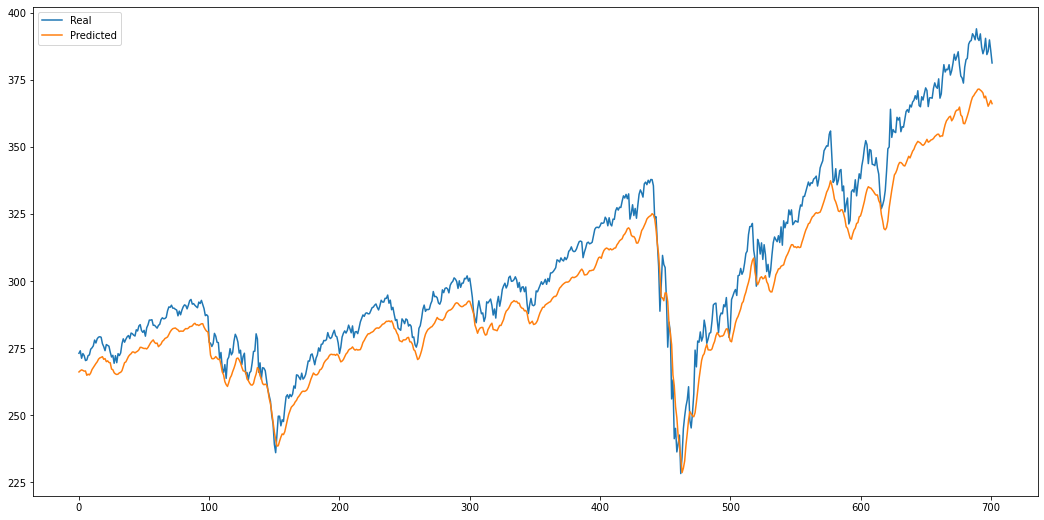

In [98]:
import matplotlib.pyplot as plt
#Plot
plt.gcf().set_size_inches(18, 9, forward=True)
real = plt.plot(unscaled_y_test[0:-1], label='real')
#Shift test predictions for plotting
pred = plt.plot(y_test_predicted[0:-1], label='predicted')
#Plot baseline and prediction
plt.legend(['Real', 'Predicted'])
plt.show()

In [99]:
#Save model for trade program
model.save(f'time_series_model.h5')